# Set Cover problem

## Set Cover Problem - Global code


In [390]:
import numpy as np
from itertools import accumulate
from matplotlib import pyplot as plt
from icecream import ic
import math

In [391]:
UNIVERSE_SIZE = 10000
NUM_SETS = 1000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [392]:
SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [393]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness_plot(fitness_values, label1, label2): 
    plt.figure(figsize=(14, 8))
    plt.plot(
       range(len(fitness_values)),
       list(accumulate(fitness_values, max)),
       color="red",
       label=label1
    )
    _ = plt.scatter(range(len(fitness_values)), fitness_values, marker=".", label=label2)
    plt.xlabel("Iteration")
    plt.ylabel("Fitness Value")
    plt.title("Hill Climbing Fitness Over Iterations")
    plt.legend()
    plt.grid(True)
    plt.show()

## First dumb solutions

In [394]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
ic(valid(solution), cost(solution))
None

ic| valid(solution): np.True_
    cost(solution): np.float64(4276221.196716479)


In [395]:
# A random solution with random 50% of the sets --> could be invalid (above all with a low number of sets)
solution = np.random.random(NUM_SETS) < 0.5
ic(valid(solution), cost(solution))
None

ic| valid(solution): np.True_
    cost(solution): np.float64(2181829.802571786)


## Hill Climbing - main utility functions

In [396]:
# First simple tweak: add/remove a random set
# SINGLE MUTATION
def tweak_1(solution):
    """Tweaks a solution by adding/removing a random set"""
    new_solution = solution.copy()
    index = rng.integers(NUM_SETS)
    new_solution[index] = not new_solution[index]
    return new_solution

# Improved tweak: iterate with a 40% of chance of a new step
# MULTPLE MUTATIONS 
def tweak_2(solution):
    new_solution = solution.copy()
    index = None
    while index is None or rng.random() < 0.4:
        index = rng.integers(NUM_SETS)
        new_solution[index] = not new_solution[index]
    return new_solution

def tweak_3(solution):
    new_solution = solution.copy()
    # Randomly decide whether to activate or deactivate a set
    activate_set = rng.random() < 0.5
    # If we decide to activate a set, look for an inactive set
    if activate_set:
        candidates = np.where(new_solution == False)[0]
        if len(candidates) > 0:
            # Randomly select a set among the inactive ones
            index = rng.choice(candidates)
            new_solution[index] = True
    else:
        # Otherwise, randomly deactivate a set among the active ones
        candidates = np.where(new_solution == True)[0]
        if len(candidates) > 0:
            index = rng.choice(candidates)
            new_solution[index] = False
    # Add an additional probability for further tweaks
    while rng.random() < 0.5:
        index = rng.integers(NUM_SETS)
        new_solution[index] = ~new_solution[index]
    return new_solution


def fitness_1(solution):
    """Returns the fitness of a solution in terms of (validity, -cost)"""
    return (valid(solution), -cost(solution))

def fitness_2(solution):
    """Returns the fitness of a solution in terms of (# of covered items, -cost)"""
    return (np.sum(np.any(SETS[solution], axis=0)), -cost(solution))

# Starting point: all sets taken
def starting_point_1():
    return rng.random(NUM_SETS) < 1

# Starting point: chance of 1% for each set to be taken
def starting_point_2():
    return rng.random(NUM_SETS) < 0.01

# Define a fixed number of steps as a stopping criterion
def stopping_criterion():
    NUM_STEPS = 150
    return range(NUM_STEPS)

# A hill-climbing algorithm
def hill_climbing(tweak, fitness, starting_point):
    solution = starting_point()
    history = [fitness(solution)]
    for _ in stopping_criterion():
        new_solution = tweak(solution)
        history.append(fitness(new_solution))
        if fitness(new_solution) > fitness(solution):
            solution = new_solution
    return solution, history


### Hill Climbing - Single random mutation

#### Single random mutation with first fitness and starting point

ic| valid(s): np.True_, cost(s): np.float64(3672424.39819666)


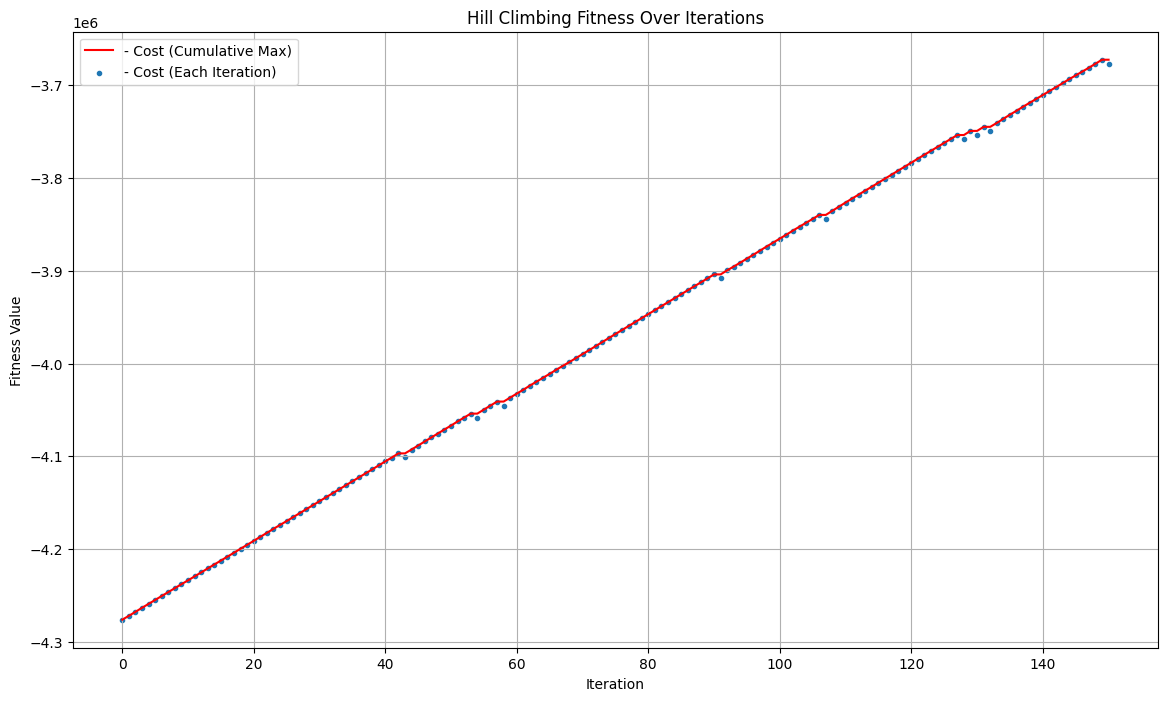

In [397]:
s, history = hill_climbing(tweak=tweak_1, fitness=fitness_1, starting_point=starting_point_1)
ic(valid(s), cost(s))

#first criterion: validity, second criterion: -cost
fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)")

None

#### Single random mutation with second fitness and starting point

ic| valid(s): np.True_, cost(s): np.float64(145719.0582755647)


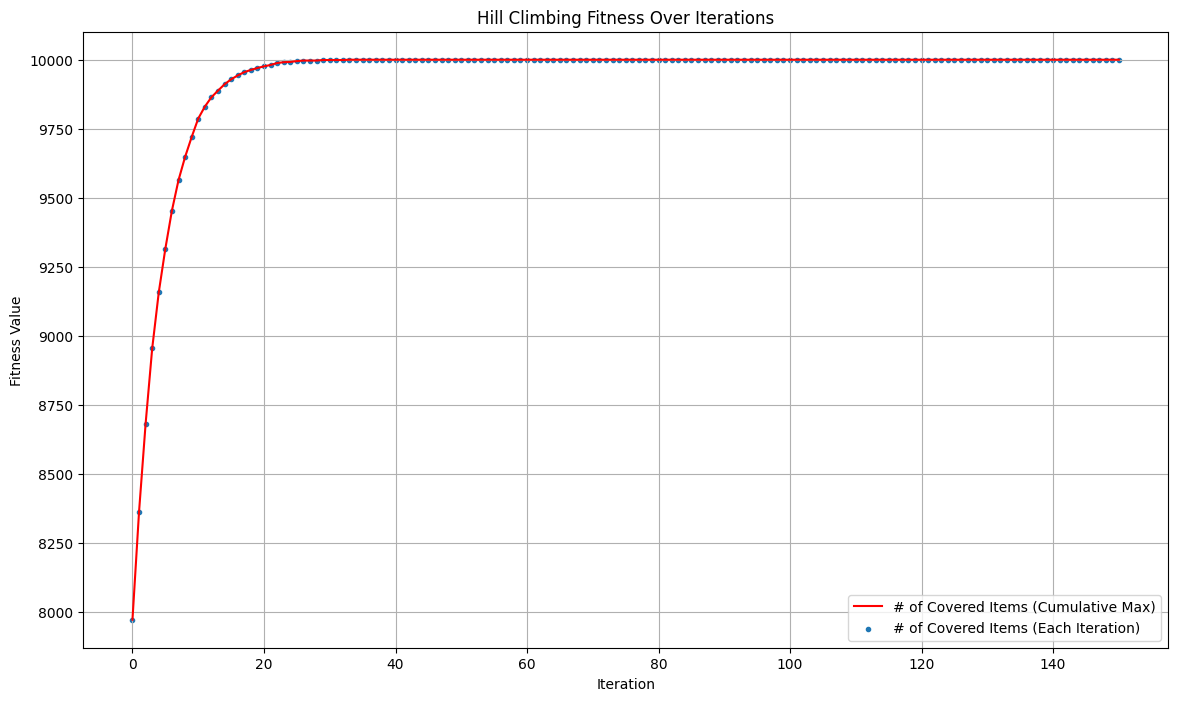

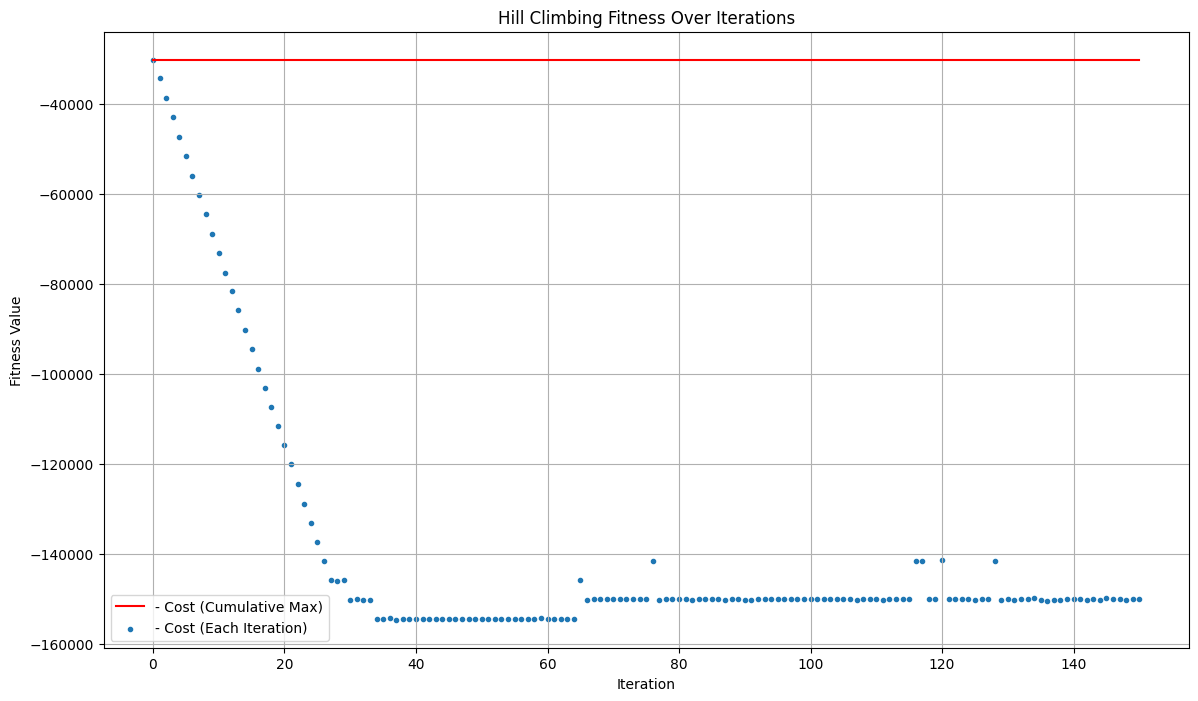

In [398]:
s, history = hill_climbing(tweak=tweak_1, fitness=fitness_2, starting_point=starting_point_2)
ic(valid(s), cost(s))

#first criterion: # of covered items, second criterion: -cost
fitness_values = [first_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values, "# of Covered Items (Cumulative Max)", "# of Covered Items (Each Iteration)")

#first criterion: validity, second criterion: -cost
fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)")

None

### Hill Climbing - Multiple random mutations

#### Multiple random mutations with first fitness and starting point

ic| valid(s): np.True_, cost(s): np.float64(3348464.961556512)


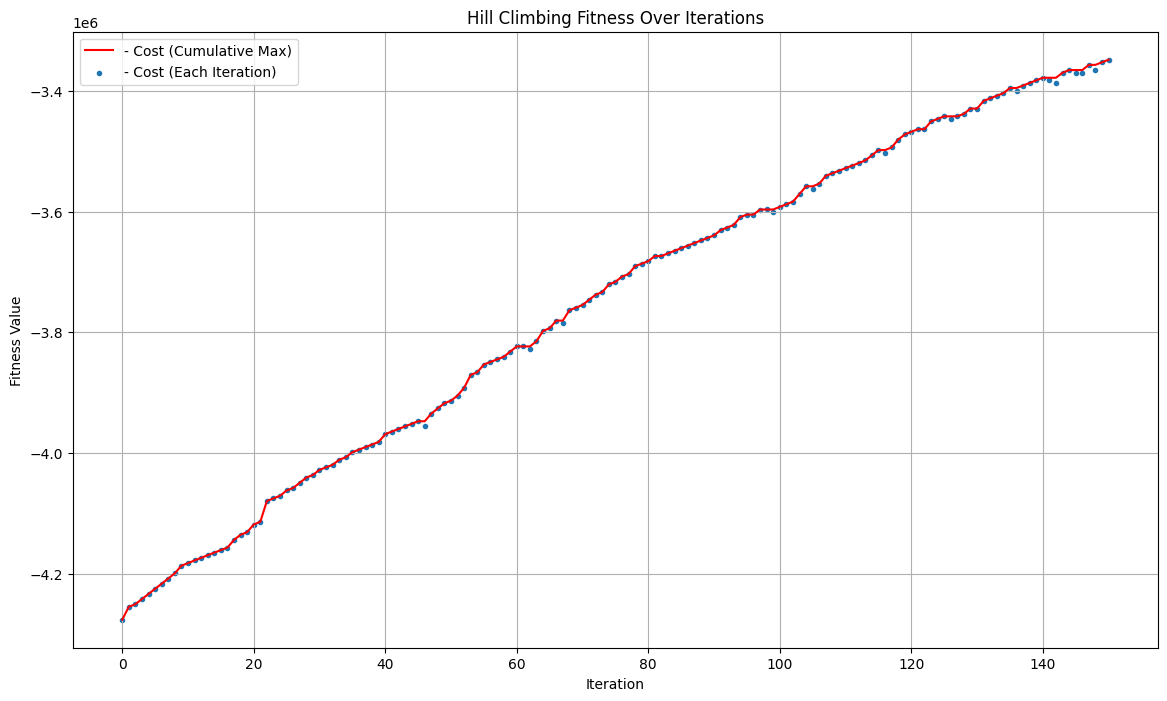

In [399]:
s, history = hill_climbing(tweak_2, fitness_1, starting_point_1)
ic(valid(s), cost(s))

#first criterion: validity, second criterion: -cost
fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)")

None

#### Multiple random mutations with second fitness and starting point

ic| valid(s): np.True_, cost(s): np.float64(162634.19594597843)


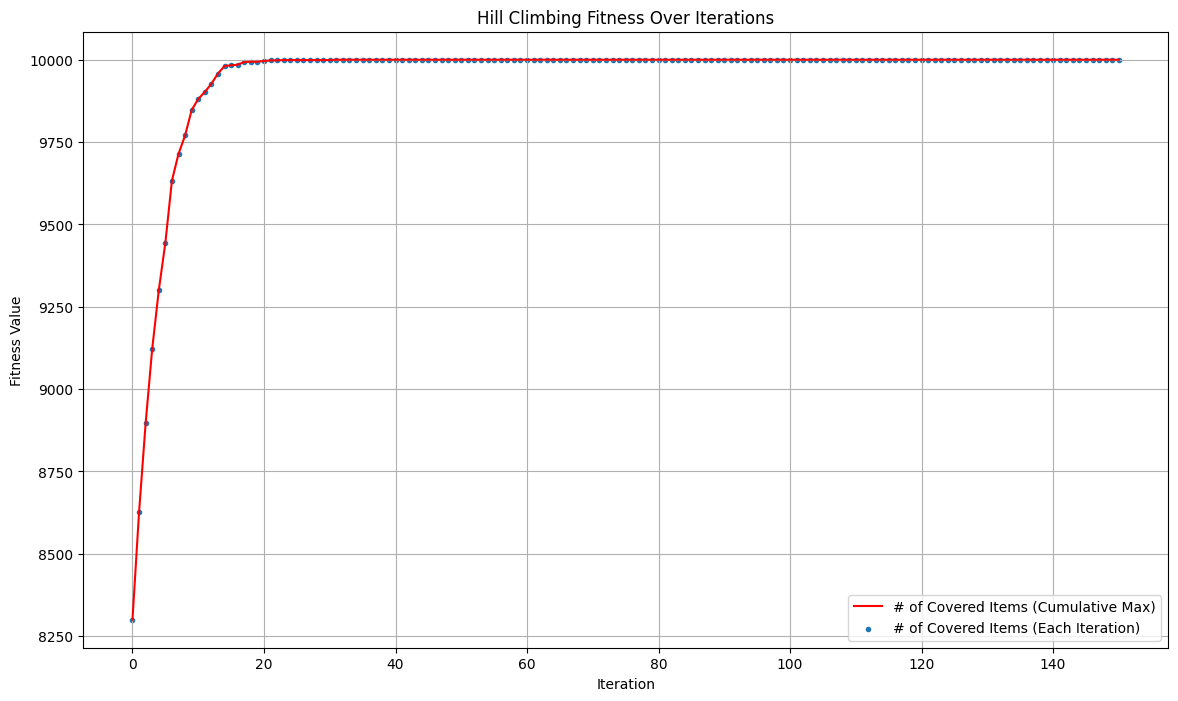

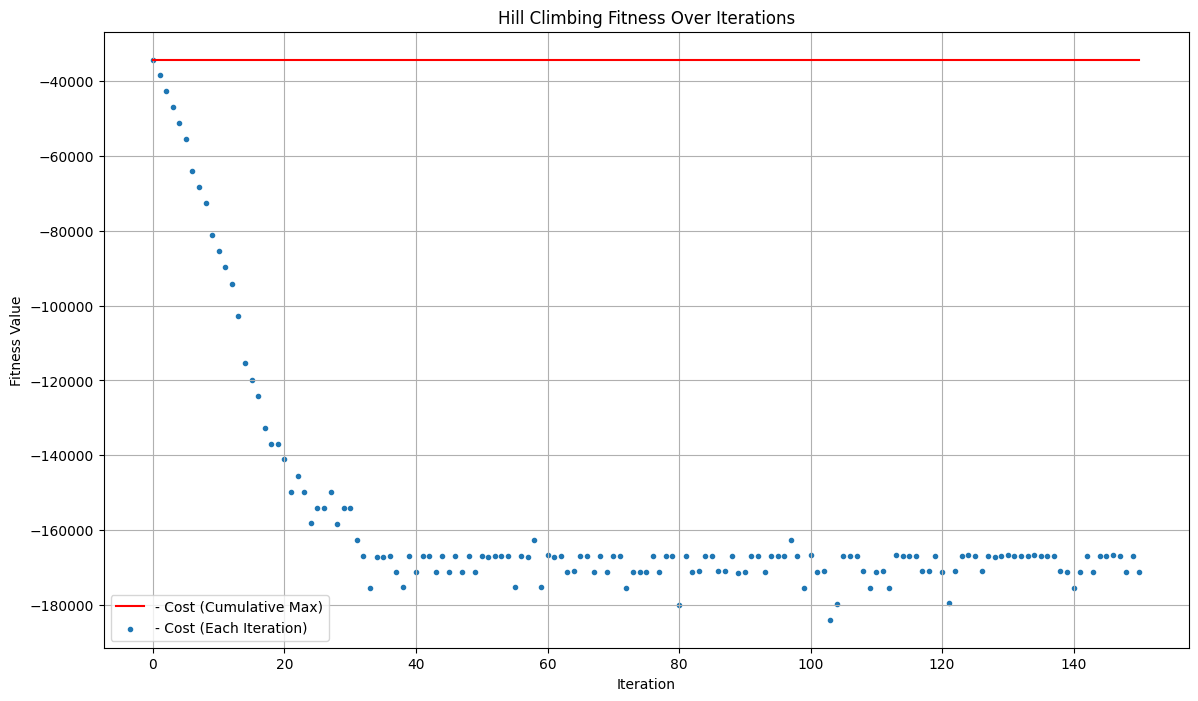

In [400]:
s, history = hill_climbing(tweak_2, fitness_2, starting_point_2)
ic(valid(s), cost(s))

#first criterion: # of covered items, second criterion: -cost
fitness_values = [first_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values, "# of Covered Items (Cumulative Max)", "# of Covered Items (Each Iteration)")

#first criterion: validity, second criterion: -cost
fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)")

None

#### Multiple random mutations with an improved tweak function

ic| valid(s): np.True_, cost(s): np.float64(131184.00779373955)


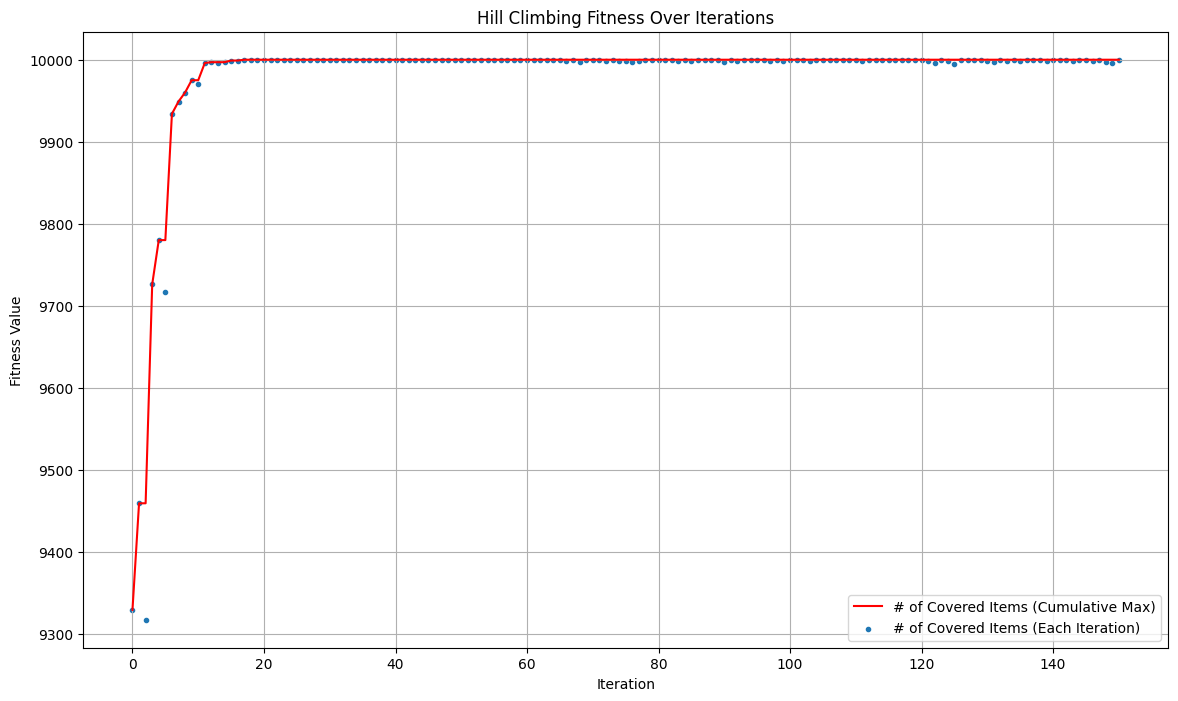

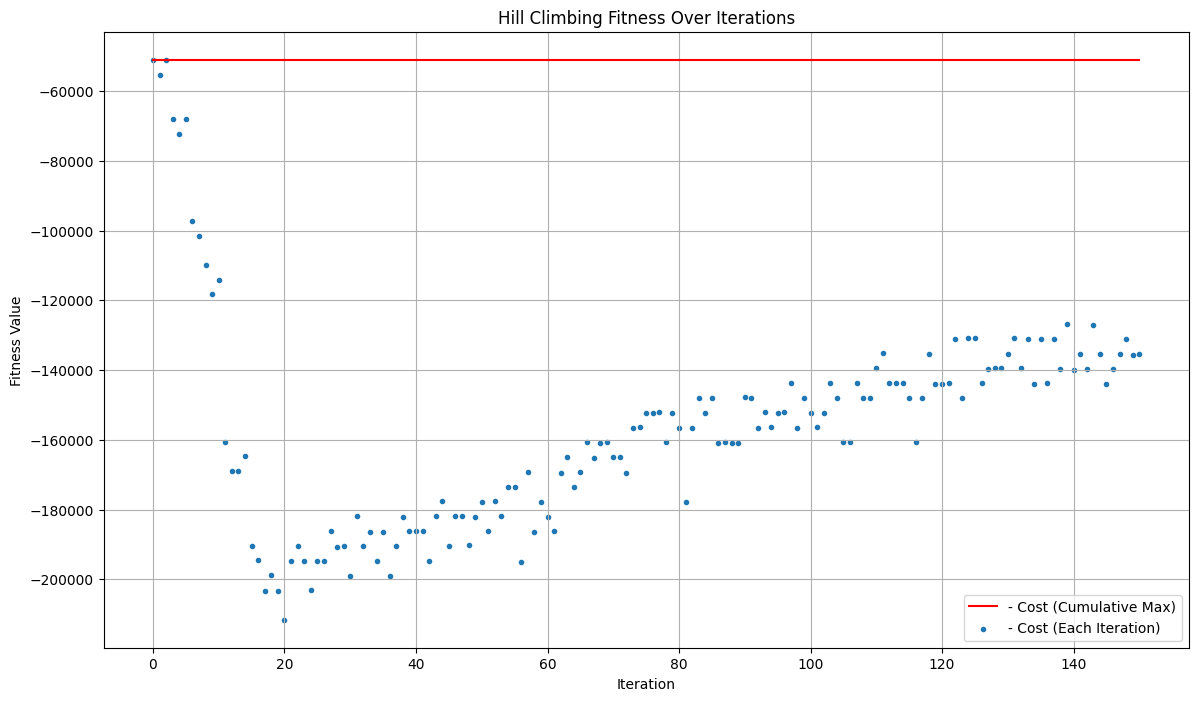

In [401]:
s, history = hill_climbing(tweak_3, fitness_2, starting_point_2)
ic(valid(s), cost(s))

#first criterion: # of covered items, second criterion: -cost
fitness_values = [first_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values, "# of Covered Items (Cumulative Max)", "# of Covered Items (Each Iteration)")

#first criterion: validity, second criterion: -cost
fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)")

None

### Hill Climbing - Steepest Step and Restart

In [402]:
NUM_RESTARTS = 3
STEEPEST_STEP_CANDIDATES = 5
TRUE_MAX_STEPS = max(stopping_criterion()) // STEEPEST_STEP_CANDIDATES

def steepest_step(solution, history, tweak=tweak_2, fitness=fitness_1):
    # Finds the best tweak among a set of candidates
    best_solution = solution
    best_fitness = fitness(solution)
    for _ in range(STEEPEST_STEP_CANDIDATES):
        candidate = tweak(solution)
        candidate_fitness = fitness(candidate)
        history.append(candidate_fitness)
        if candidate_fitness > best_fitness:
            best_solution = candidate
            best_fitness = candidate_fitness
    return best_solution

def hill_climbing_with_restarts(init_fitness, fitness, starting_point):
    # Performs hill climbing with multiple restarts
    best_solution = None
    best_fitness = init_fitness
    history = list()

    for _ in range(NUM_RESTARTS):
        solution = starting_point()
        history.append(fitness(solution))
        for _ in range(TRUE_MAX_STEPS // NUM_RESTARTS):
            new_solution = steepest_step(solution, history, fitness=fitness)
            if fitness(new_solution) > fitness(solution):
                solution = new_solution
        if fitness(solution) > best_fitness:
            best_solution = solution
            best_fitness = fitness(solution)
    return best_solution, history



#### Steepest Step and Restart with first fitness and starting point

ic| valid(s): np.True_, cost(s): np.float64(4156335.1273893416)


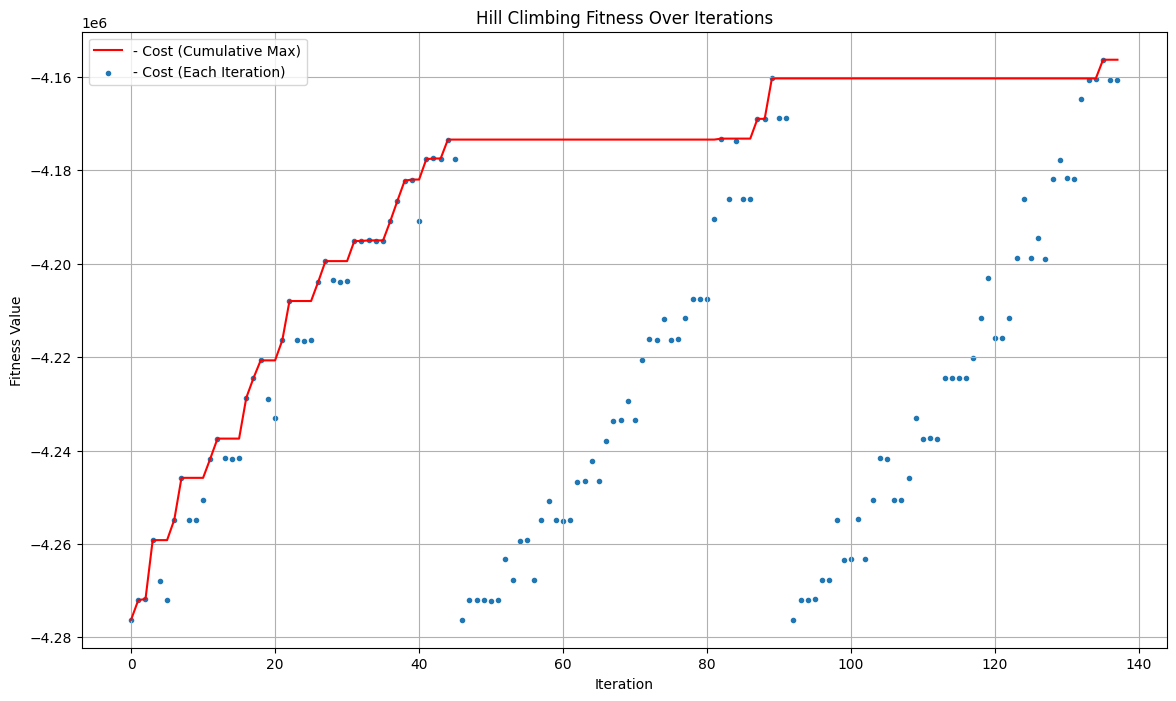

In [403]:
init_fitness = (False, float('-inf'))
s, history = hill_climbing_with_restarts(init_fitness, fitness=fitness_1, starting_point=starting_point_1)
ic(valid(s), cost(s))

#first criterion: validity, second criterion: -cost
fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)")

None

#### Steepest Step and Restart with second fitness and starting point

ic| valid(s): np.True_, cost(s): np.float64(179502.41809078594)


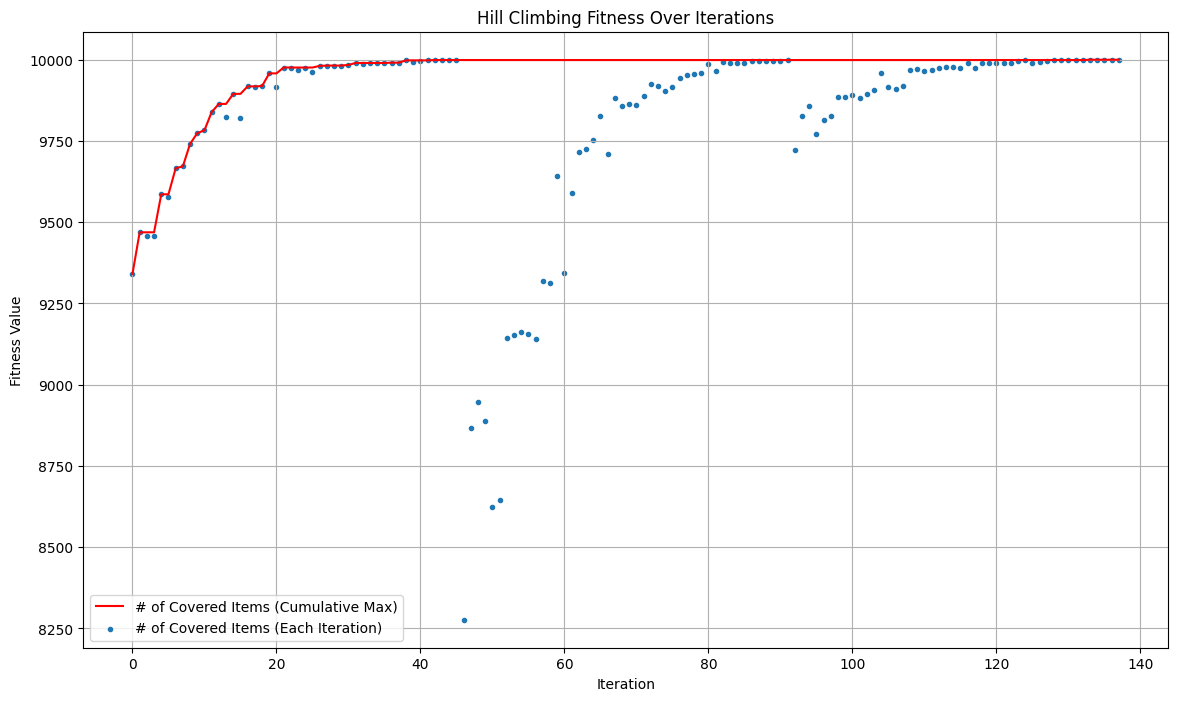

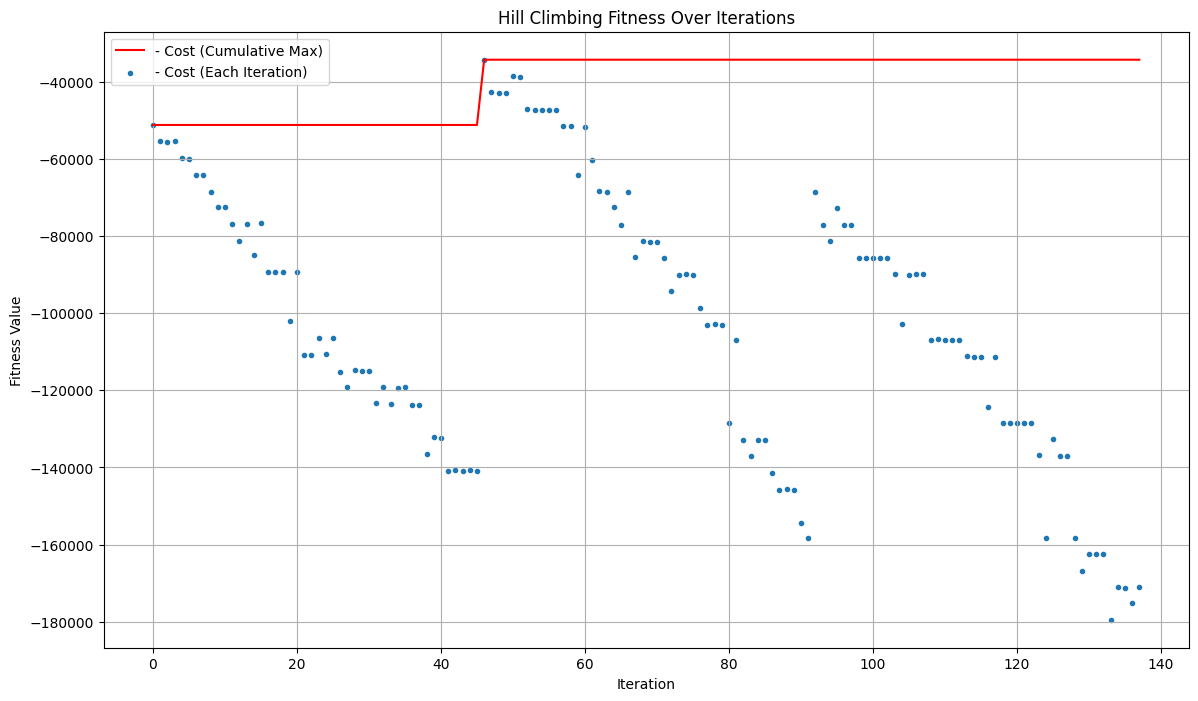

In [404]:
init_fitness = (0, float('-inf'))
s, history = hill_climbing_with_restarts(init_fitness, fitness=fitness_2, starting_point=starting_point_2)
ic(valid(s), cost(s))

#first criterion: # of covered items, second criterion: -cost
fitness_values = [first_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values, "# of Covered Items (Cumulative Max)", "# of Covered Items (Each Iteration)")

#first criterion: validity, second criterion: -cost
fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)")

None

## Simulated Annealing

In [405]:
INITIAL_TEMPERATURE = 1000  # Initial temperature
COOLING_RATE = 0.995  # Cooling factor
threshold_stop = 1e-10  # Threshold for stopping the algorithm

def simulated_annealing(tweak, starting_point, fitness, penalty_weight=1e6):
    # Initial starting point
    S = starting_point()  # Initial solution
    best_solution = S.copy()  # Best solution found so far
    current_fitness = fitness(S)  # Fitness of the current solution
    current_value, current_cost = current_fitness  # Decompose into value and cost

    # Apply penalty if solution is not valid
    current_penalty = penalty_weight * (not valid(S))  # Large penalty for invalid solutions
    current_cost -= current_penalty  # Adjust cost with penalty

    # Temperature initialization
    temperature = INITIAL_TEMPERATURE

    # History to track the evolution of fitness (value, cost)
    history = [(current_value, current_cost)]

    # Main loop
    while temperature > threshold_stop:
        # Create a new solution by tweaking the current one
        R = tweak(S.copy())  # Tweak the current solution
        new_fitness = fitness(R)  # Fitness of the new solution
        new_value, new_cost = new_fitness  # Decompose into value and cost

        # Apply penalty if solution is not valid
        new_penalty = penalty_weight * (not valid(R))  # Large penalty for invalid solutions
        new_cost -= new_penalty  # Adjust cost with penalty

        # Calculate the change in energy (cost) from S to R
        delta_cost = new_cost - current_cost

        # If the new solution is better or accepted probabilistically
        if delta_cost > 0 or rng.random() < math.exp(delta_cost / temperature):
            S = R  # Update the current solution
            current_value, current_cost = new_value, new_cost  # Update value and cost
            history.append((current_value, current_cost))  # Store in history

            # Update best_solution if the new solution is better and valid
            if new_cost > fitness(best_solution)[1] and valid(R):  # Ensure solution is valid before updating best_solution
                best_solution = S.copy()  # Update the best solution

        # Reduce the temperature according to the cooling schedule
        temperature *= COOLING_RATE

    return best_solution, history  # Return the best solution found and the fitness history


ic| valid(s): np.True_, cost(s): np.float64(118044.7930952586)


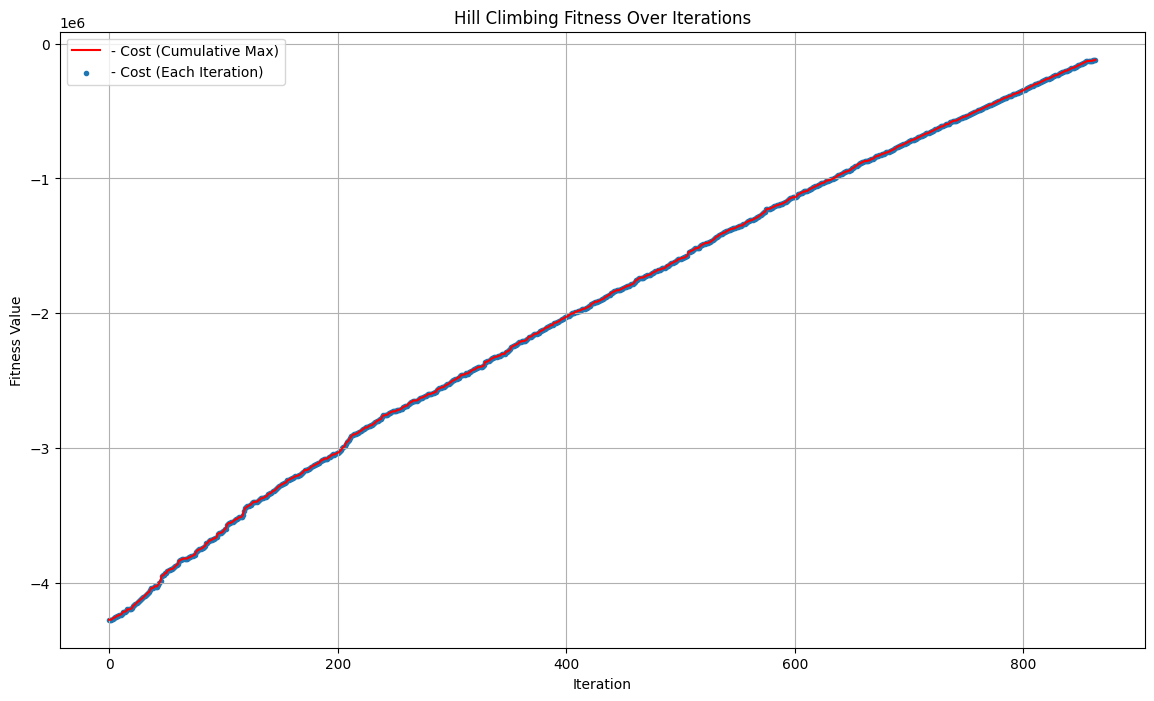

In [422]:
# Run the Simulated Annealing algorithm
s, history = simulated_annealing(tweak_3, starting_point_1, fitness_1)
ic(valid(s), cost(s))

#first criterion: validity, second criterion: -cost
fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)")

None

### Tabu Search

In [420]:
def tabu_search(tweak, starting_point, fitness, tabu_size=50, max_iterations=1000, penalty_weight=1e6):
    """
    Perform Tabu Search to find a near-optimal solution for the Set Covering Problem.

    Args:
    - tweak: Function to slightly modify the solution.
    - starting_point: Function to provide the initial solution.
    - fitness: Function to evaluate the fitness of a solution.
    - tabu_size: Maximum size of the tabu list (memory size).
    - max_iterations: Maximum number of iterations to perform.
    - penalty_weight: Penalty for invalid solutions to prioritize valid ones.

    Returns:
    - best_solution: The best solution found.
    - history: A list of fitness values over the iterations.
    """

    # Initial starting point
    S = starting_point()  # Initial solution
    best_solution = S.copy()  # Best solution found so far
    current_fitness = fitness(S)  # Fitness of the current solution
    current_value, current_cost = current_fitness  # Decompose into value and cost

    # Apply penalty if solution is not valid
    current_penalty = penalty_weight * (not valid(S))  # Large penalty for invalid solutions
    current_cost -= current_penalty  # Adjust cost with penalty

    # History to track the evolution of fitness (value, cost)
    history = [(current_value, current_cost)]

    # Tabu list to store recent solutions or solution hashes (for quick comparison)
    tabu_list = []

    # Main loop with a set number of iterations
    for iteration in range(max_iterations):
        # Generate neighborhood solutions by tweaking the current one
        neighborhood = [tweak(S.copy()) for _ in range(10)]  # Generate multiple neighbors

        # Evaluate the fitness of all neighbors
        neighborhood_fitness = []
        for neighbor in neighborhood:
            fitness_value = fitness(neighbor)
            value, cost = fitness_value

            # Apply penalty if the solution is not valid
            penalty = penalty_weight * (not valid(neighbor))  # Large penalty for invalid solutions
            cost -= penalty  # Adjust cost with penalty
            neighborhood_fitness.append((value, cost))

        # Select the best non-tabu neighbor
        best_neighbor, best_neighbor_fitness = None, (-float('inf'), -float('inf'))
        for neighbor, (value, cost) in zip(neighborhood, neighborhood_fitness):
            # Use a tuple of the neighbor solution to compare with the tabu list
            if not (neighbor.tobytes() in tabu_list):
                if cost > best_neighbor_fitness[1]:  # Check if the current neighbor is better
                    best_neighbor, best_neighbor_fitness = neighbor, (value, cost)

        # Update current solution to the best found neighbor
        if best_neighbor is not None:
            S = best_neighbor  # Move to the best neighbor
            current_value, current_cost = best_neighbor_fitness  # Update fitness values
            history.append(best_neighbor_fitness)  # Track progress

            # If new solution is better than best solution found so far
            if best_neighbor_fitness[1] > fitness(best_solution)[1] and valid(S):
                best_solution = S.copy()  # Update best solution

            # Add the move or solution to the tabu list
            tabu_list.append(S.tobytes())  # Add as bytes for quick comparison
            if len(tabu_list) > tabu_size:
                tabu_list.pop(0)  # Keep the tabu list at a fixed size

    return best_solution, history  # Return the best solution found and the fitness history


ic| valid(s): np.True_, cost(s): np.float64(125539.02610223583)


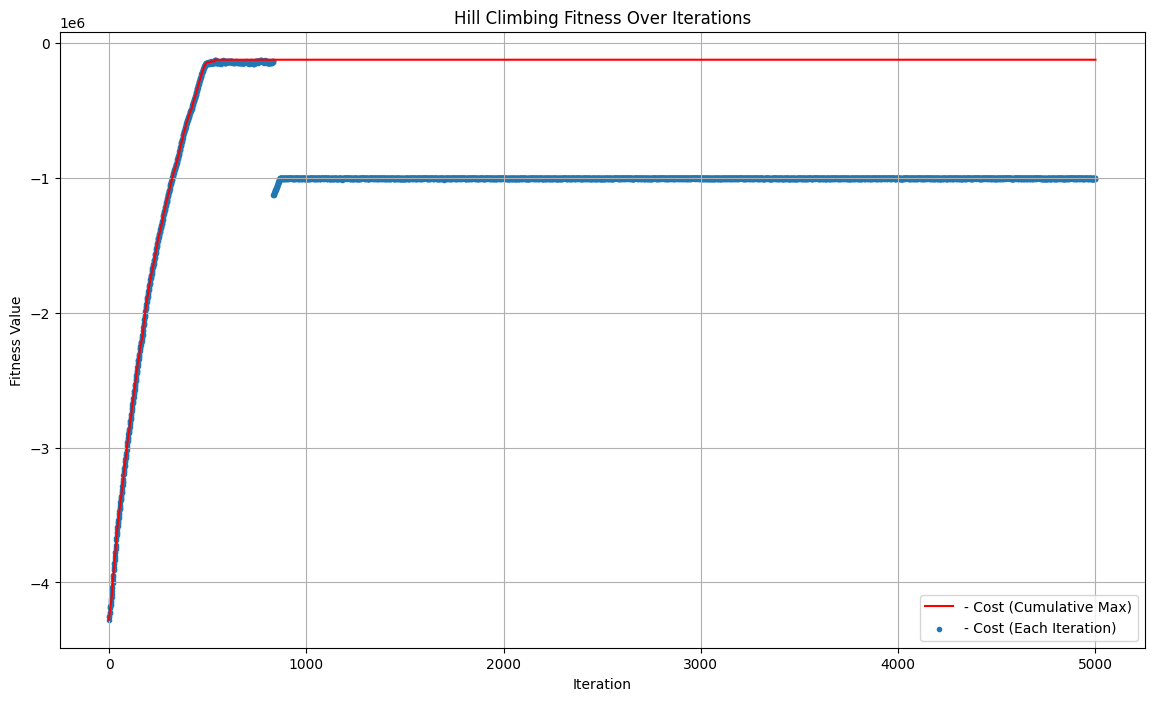

In [419]:
# Run the Tabu Search algorithm
s, history = tabu_search(tweak_3, starting_point_1, fitness_1)
ic(valid(s), cost(s))

#first criterion: validity, second criterion: -cost
fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)")

None